## Analyzing keio plate 5

This notebook runs the analysis pipeline for the data for Keio plate 5 collected on 08142017.

In [23]:
#Import packages
import numpy as np 
import os
import tifffile as tiff
from skimage.io import imread
from skimage.measure import label, regionprops
import scipy
import matplotlib.pyplot as plt
import cPickle as pickle
from SLIP_functions import analyze_well, analyze_plate, segment_SLIP, plot_slip_well, plot_slip_wells
from SLIP_functions import plot_slip_joint_plot, fit_kde, compute_p_values
from SLIP_functions import classify_infections, compute_p_lysis_posterior, compute_MOI_posterior
from keio_names import get_keio_names, pos_to_strain
import seaborn as sns
import pandas as pd
import pymc3 as pm

sns.set_context('notebook', font_scale = 1.1)
sns.set_style('white')
sns.set_style('ticks')

#Activate matplotlib inline
%matplotlib inline

#Define root directory path
root_direc = "/media/vanvalen/693d2597-3dbf-41bb-b919-341f714e3199/keio_screen/08.14.2017/keio5"
plate_number = 5

#Define directory path to infection data (all positions)
data_direc = os.path.join(root_direc, 'data')

#Define directory path to control data (all positions)
control_direc = os.path.join(root_direc, 'control')

#Define directory path to where you want to store neural net outputs. 
#mask directories must exist at run time!
mask_direc = os.path.join(root_direc, 'masks')
control_mask_direc = os.path.join(root_direc,'control_masks')

In [24]:
#Define which wells were used
row_control = ['A']
col_control = [9]

row_data = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
col_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [25]:
#Load saved data
mean_FITC_name = os.path.join(root_direc, 'mean_FITC.pkl')
mean_cherry_name = os.path.join(root_direc, 'mean_cherry.pkl')
mean_FITC = pickle.load(open(mean_FITC_name, 'rb'))
mean_cherry = pickle.load(open(mean_cherry_name, 'rb'))

mean_FITC_control_name = os.path.join(root_direc, 'mean_FITC_control.pkl')
mean_cherry_control_name = os.path.join(root_direc, 'mean_cherry_control.pkl')
mean_FITC_control = pickle.load(open(mean_FITC_control_name, 'rb'))
mean_cherry_control = pickle.load(open(mean_cherry_control_name, 'rb'))

p_values_dict_name = os.path.join(root_direc, 'p_values_dict.pkl')
p_values_dict = pickle.load(open(p_values_dict_name, 'rb'))

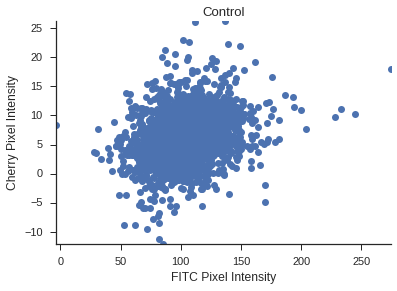

In [26]:
#Plot the data from the control plate
plot_slip_well(mean_FITC_control, mean_cherry_control, well = 'A9', title = 'Control')
sns.despine()

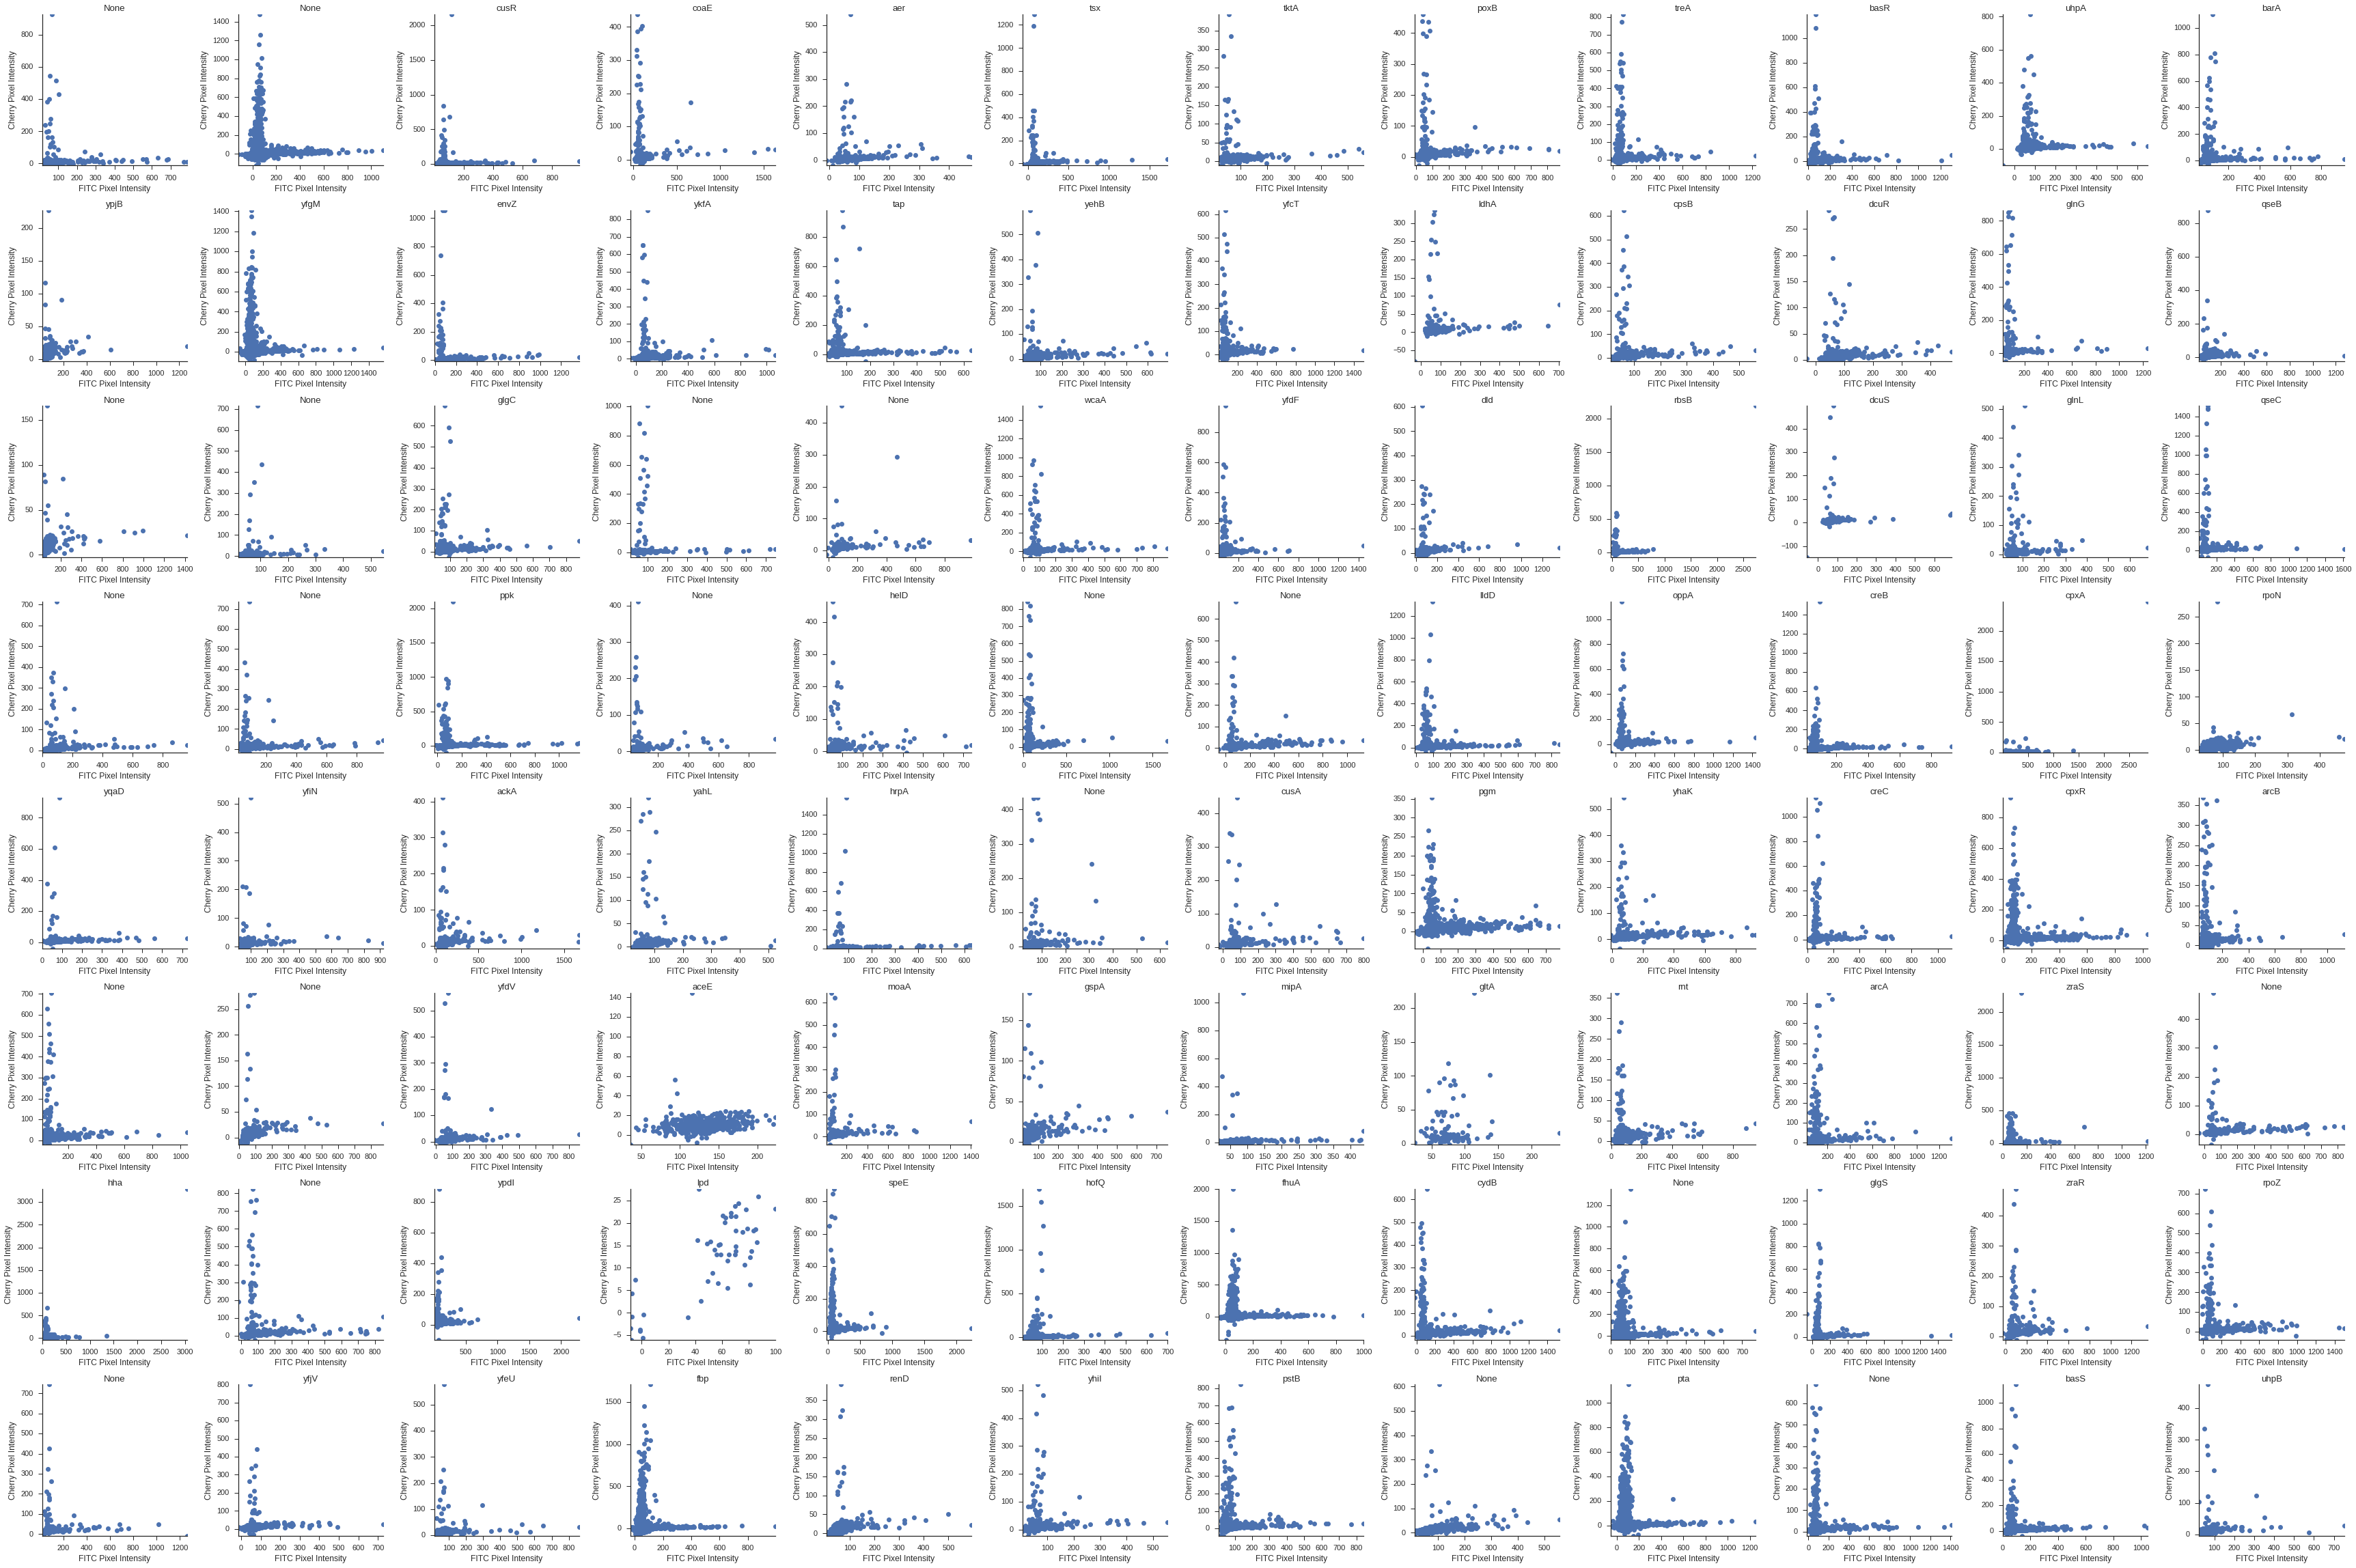

In [27]:
#Plot the scatter plot of intensities
wells = []
titles = []
keio_names_array = get_keio_names()

for row in row_data:
    for col in col_data:
        well = row + str(col)
        wells += [well]
        titles += [pos_to_strain(keio_names_array, plate_number, well)]
        
plot_slip_wells(mean_FITC, mean_cherry, wells = wells, titles = titles)
sns.despine()

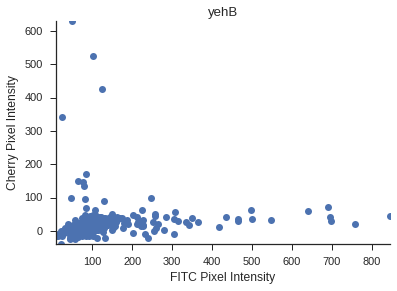

In [14]:
#Print specific wells
well = "B6"
fitc_list = np.array(mean_FITC[well])
cherry_list = np.array(mean_cherry[well])
fig = plt.figure()
plt.plot(fitc_list, cherry_list, 'o')
plt.xlabel('FITC Pixel Intensity')
plt.ylabel('Cherry Pixel Intensity')
plt.title(pos_to_strain(keio_names_array, plate_number, well))
xmax = max(fitc_list)
xmin = min(fitc_list)
ymax = max(cherry_list)
ymin = min(cherry_list)
plt.axis([xmin, xmax, ymin, ymax])
sns.despine()

In [28]:
#Print the number of cells in each well
for key in mean_FITC_control.keys():
    print key, len(mean_FITC_control[key])
    
for key in mean_FITC.keys():
    print key, len(mean_FITC[key])

A9 2635
G7 3767
G6 618
G5 813
G4 50
G3 573
G2 827
G1 594
G9 1352
G8 1058
B4 883
B5 766
B6 362
B7 891
B1 251
B2 5742
B3 464
B8 368
B9 478
E9 620
E8 2294
E5 333
E4 306
E7 420
E6 456
E1 301
E3 389
E2 233
H10 1383
H11 1289
H12 345
F12 353
F10 729
F11 1717
H8 1002
H9 5528
H2 2211
H3 308
H1 287
H6 635
H7 1643
H4 4714
H5 821
D10 1096
D11 564
D12 490
B12 738
B10 422
B11 697
C9 1855
C8 1124
C3 649
C2 228
C1 189
C7 715
C6 1564
C5 285
C4 304
G12 1094
G11 606
G10 1012
F1 854
F2 1122
F3 381
F4 460
F5 383
F6 292
F7 864
F8 108
F9 1027
E11 1168
E10 955
E12 700
C12 792
C11 397
C10 228
A11 1163
A10 1228
A12 798
A1 417
A3 918
A2 5561
A5 519
A4 694
A7 464
A6 1120
A9 1713
A8 1644
D8 1085
D9 1491
D6 859
D7 685
D4 327
D5 279
D2 741
D3 1029
D1 414


In [29]:
# Fit a KDE estimator to the no infection control
kernel = fit_kde(mean_FITC_control, mean_cherry_control, 'A9')

In [30]:
#Compute the fraction infected in each well and plot
conc_list = []
fraction_infected_list = []
for well in p_values_dict.keys():
    p_value = p_values_dict[well]
    fraction_infected = np.float(np.where(p_value < 0.01)[0].shape[0])/np.float(p_value.shape[0])
    fraction_infected_list += [fraction_infected]
    
    print well, fraction_infected

G7 0.11361826387
G6 0.18932038835
G5 0.30381303813
G4 0.34
G3 0.265270506108
G2 0.224909310762
G1 0.5
G9 0.304733727811
G8 0.366729678639
B4 0.166477916195
B5 0.231070496084
B6 0.328729281768
B7 0.181818181818
B1 0.215139442231
B2 0.122082897945
B3 0.275862068966
B8 0.149456521739
B9 0.332635983264
E9 0.301612903226
E8 0.148648648649
E5 0.291291291291
E4 0.153594771242
E7 0.257142857143
E6 0.131578947368
E1 0.269102990033
E3 0.311053984576
E2 0.287553648069
H10 0.297903109183
H11 0.213343677269
H12 0.214492753623
F12 0.29178470255
F10 0.336076817558
F11 0.148514851485
H8 0.155688622754
H9 0.166787264834
H2 0.102668475803
H3 0.340909090909
H1 0.714285714286
H6 0.16062992126
H7 0.180158247109
H4 0.120280016971
H5 0.241169305725
D10 0.165145985401
D11 0.374113475177
D12 0.114285714286
B12 0.151761517615
B10 0.189573459716
B11 0.16212338594
C9 0.0501347708895
C8 0.0747330960854
C3 0.181818181818
C2 0.166666666667
C1 0.253968253968
C7 0.160839160839
C6 0.0875959079284
C5 0.19649122807
C4 0.

None 9 20
None 94 340
cusR 15 31
coaE 19 38
aer 6 18
tsx 11 32
tktA 6 18
poxB 11 32
treA 27 74
basR 25 52
uhpA 7 57
barA 14 58
ypjB 3 3
yfgM 64 323
envZ 21 31
ykfA 12 30
tap 20 49
yehB 7 13
yfcT 15 43
ldhA 4 12
cpsB 7 27
dcuR 11 14
glnG 6 43
qseB 9 13
None 3 4
None 6 10
glgC 7 27
None 9 24
None 5 5
wcaA 1 36
yfdF 6 29
dld 5 17
rbsB 9 19
dcuS 2 8
glnL 3 23
qseC 5 49
None 4 17
None 13 23
ppk 19 54
None 7 13
helD 4 14
None 16 55
None 19 23
lldD 12 52
oppA 20 52
creB 12 51
cpxA 13 2
rpoN 1 1
yqaD 4 10
yfiN 3 7
ackA 9 18
yahL 5 14
hrpA 5 16
None 3 14
cusA 6 13
pgm 74 57
yhaK 7 32
creC 18 45
cpxR 30 114
arcB 4 47
None 4 43
None 2 8
yfdV 8 9
aceE 23 2
moaA 2 22
gspA 4 9
mipA 2 6
gltA 0 10
rnt 10 27
arcA 24 51
zraS 3 43
None 7 19
hha 4 33
None 10 50
ypdI 9 31
speE 9 79
hofQ 7 40
fhuA 26 192
cydB 34 70
None 4 235
glgS 4 62
zraR 4 31
rpoZ 34 67
None 1 18
yfjV 4 19
yfeU 4 15
fbp 25 224
renD 0 12
yhiI 1 28
pstB 19 76
None 1 8
pta 80 391
None 16 78
basS 19 75
uhpB 1 10


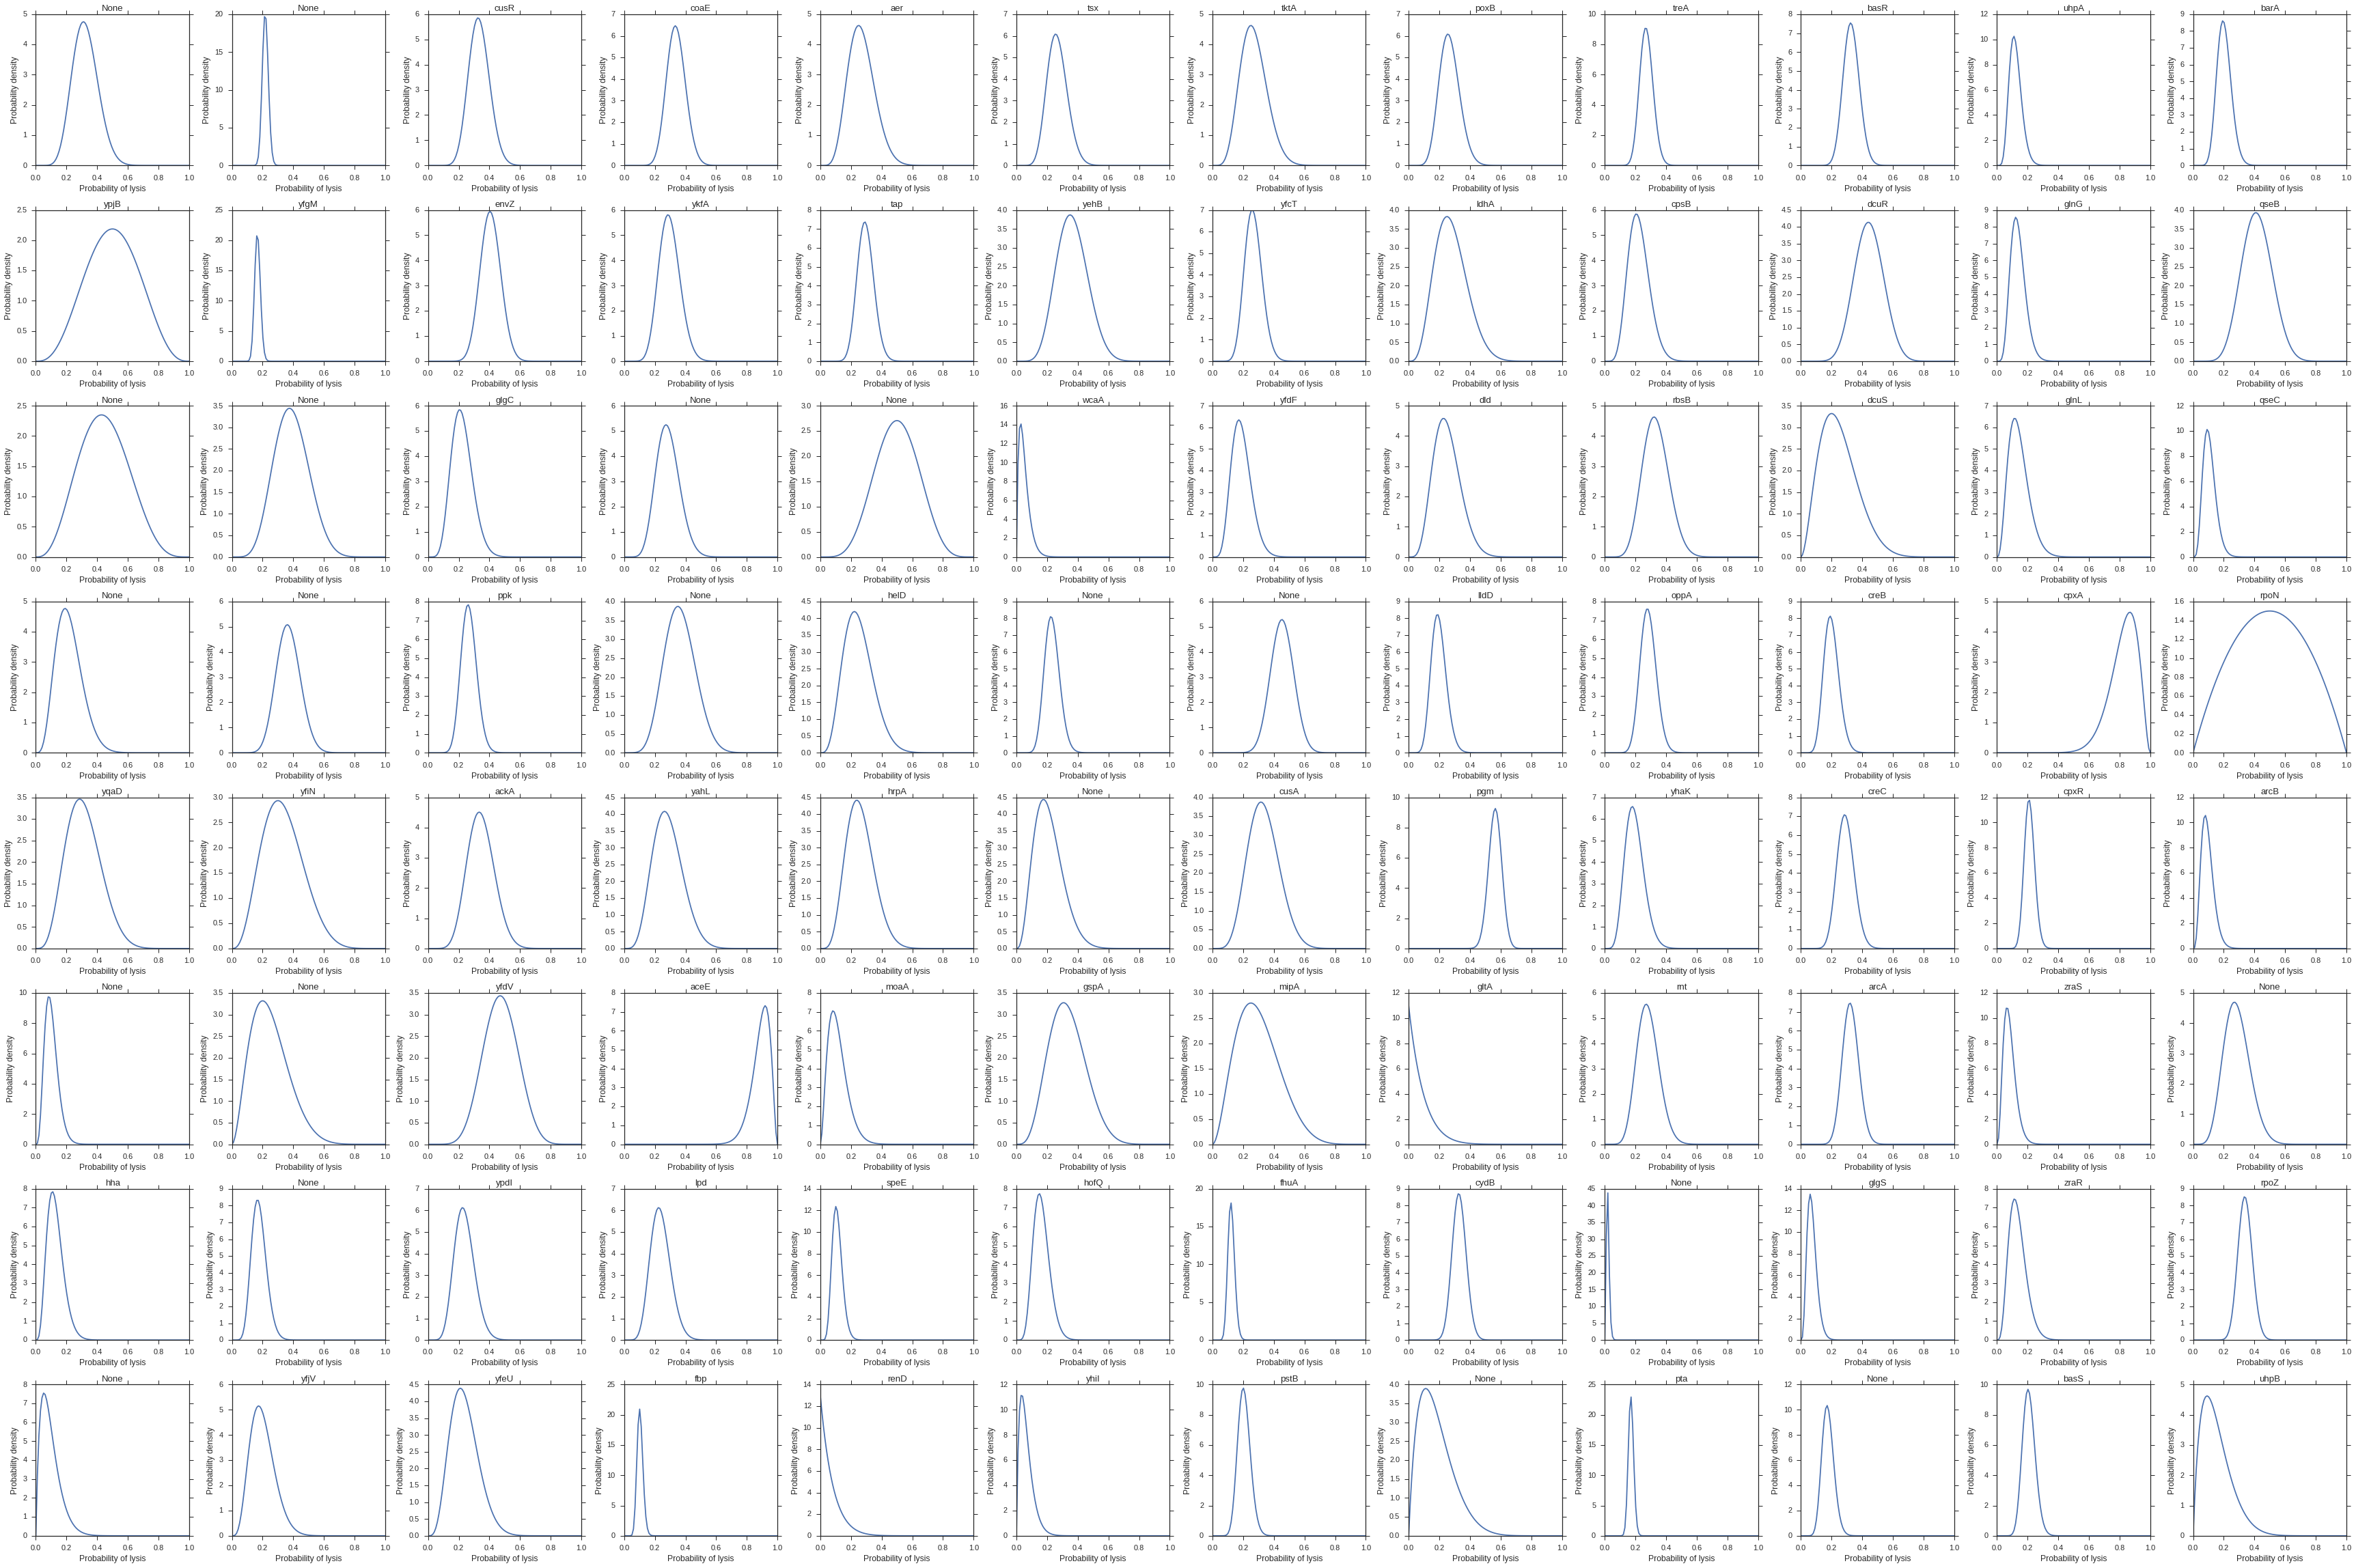

In [31]:
# Use the no phage control to construct a lysis/lysogeny classifier
fitc_control_array = np.array(mean_FITC_control['A9'])
cherry_control_array = np.array(mean_cherry_control['A9'])
kernel_fitc = scipy.stats.gaussian_kde(fitc_control_array)
kernel_cherry = scipy.stats.gaussian_kde(cherry_control_array)

def compute_p_lysis_posterior(N_lysis, N_lysogeny):
    x = np.linspace(0,1,100)
    posterior= scipy.stats.beta.pdf(x, 1+N_lysis, 1+N_lysogeny)
    return x, posterior

# d = classify_infections(kernel_fitc, kernel_cherry, p_values_dict, rows = row_data, cols = col_data)

kn = get_keio_names()
fig, axes = plt.subplots(8,12, figsize = (4*12, 4*8))

for row in row_data:
    for col in col_data:
        well = row + str(col)
        
        well_name = pos_to_strain(kn, plate = plate_number, pos = well)
        p_value = p_values_dict[well]
        infected_cells = np.where(p_value < 0.01)[0]
        fitc_list = np.array(mean_FITC[well])[infected_cells]
        cherry_list = np.array(mean_cherry[well])[infected_cells]

        p_fitc = []
        p_cherry = []
        for fitc, cherry in zip(fitc_list, cherry_list):
            p_fitc += [1-kernel_fitc.integrate_box_1d(fitc, 1e6)]
            p_cherry += [1-kernel_cherry.integrate_box_1d(cherry, 1e6)]

        # Remove double positives
        p_fitc_new = []
        p_cherry_new = []
        fitc_list_new = []
        cherry_list_new = []
        for p_f, p_c, f, c in zip(p_fitc, p_cherry, fitc_list, cherry_list):
            if (p_f < 0.85 and c > 50) or p_c < 0.85:
                p_fitc_new += [p_f]
                p_cherry_new += [p_c]
                fitc_list_new += [f]
                cherry_list_new += [c]

        p_fitc = p_fitc_new
        p_cherry = p_cherry_new
        fitc_list = fitc_list_new
        cherry_list = cherry_list_new

        d = {'FITC Probability': p_fitc, 'Cherry Probability': p_cherry}
        dataframe = pd.DataFrame(data = d)
#         grid = sns.lmplot('FITC Probability', 'Cherry Probability', dataframe, fit_reg = False)
#         ax = grid.axes[0][0]
#         ax.set_title(well_name)
#         ax.set_xlim([-0.05, 1.05])
#         ax.set_ylim([-0.05, 1.05])

        d = {'FITC Intensity': fitc_list, 'Cherry Intensity': cherry_list}
        dataframe = pd.DataFrame(data = d)
#         grid = sns.lmplot('FITC Intensity', 'Cherry Intensity', dataframe, fit_reg = False, scatter_kws = {'color': 'red'})
#         ax = grid.axes[0][0]
#         ax.set_title(well_name)

        counter = 0
        for p_f, p_c in zip(p_fitc, p_cherry):
            if p_f > p_c:
                counter += 1
                
        if len(p_fitc) > 0:
            #Uncomment to print p_lysis
            #print well_name, np.float(counter)/len(p_fitc), counter, len(p_fitc)
            print well_name, counter, len(p_fitc)-counter
            x, posterior = compute_p_lysis_posterior(counter, len(p_fitc) - counter)
            
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 1])
            axes[row_temp, col_temp].set_xlabel('Probability of lysis')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
        else:    
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 1])
            axes[row_temp, col_temp].set_xlabel('Probability of lysis')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
            
plt.tight_layout()
    

cpxA 31 2


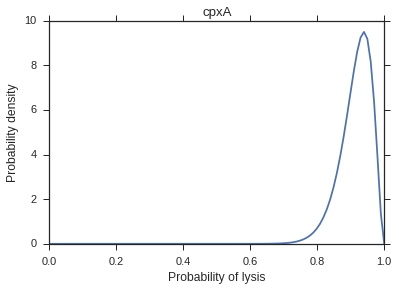

In [21]:
well = "D11"
        
well_name = pos_to_strain(kn, plate = plate_number, pos = well)
p_value = p_values_dict[well]
infected_cells = np.where(p_value < 0.01)[0]
fitc_list = np.array(mean_FITC[well])[infected_cells]
cherry_list = np.array(mean_cherry[well])[infected_cells]

p_fitc = []
p_cherry = []
for fitc, cherry in zip(fitc_list, cherry_list):
    p_fitc += [1-kernel_fitc.integrate_box_1d(fitc, 1e6)]
    p_cherry += [1-kernel_cherry.integrate_box_1d(cherry, 1e6)]

# Remove double positives
p_fitc_new = []
p_cherry_new = []
fitc_list_new = []
cherry_list_new = []
for p_f, p_c, f, c in zip(p_fitc, p_cherry, fitc_list, cherry_list):
    if (p_f < 0.85 and c > 50) or p_c < 0.85:
        p_fitc_new += [p_f]
        p_cherry_new += [p_c]
        fitc_list_new += [f]
        cherry_list_new += [c]

p_fitc = p_fitc_new
p_cherry = p_cherry_new
fitc_list = fitc_list_new
cherry_list = cherry_list_new

counter = 0
for p_f, p_c in zip(p_fitc, p_cherry):
    if p_f > p_c:
        counter += 1
                
if len(p_fitc) > 0:
    #Uncomment to print p_lysis
    #print well_name, np.float(counter)/len(p_fitc), counter, len(p_fitc)
    print well_name, counter, len(p_fitc)-counter
    x, posterior = compute_p_lysis_posterior(counter, len(p_fitc) - counter)

    alphabet = ['A','B','C','D','E','F','G','H']
    chars = list(well)
    row_temp = alphabet.index(chars[0])
    if len(chars) == 2:
        col_temp = int(chars[1])-1
    if len(chars) == 3:
        col_temp = int(chars[1] + chars[2])-1
    fig = plt.figure()
    axes = plt.gca()
    axes.plot(x, posterior)
    axes.set_xlim([0, 1])
    axes.set_xlabel('Probability of lysis')
    axes.set_ylabel('Probability density')
    axes.set_title(well_name)

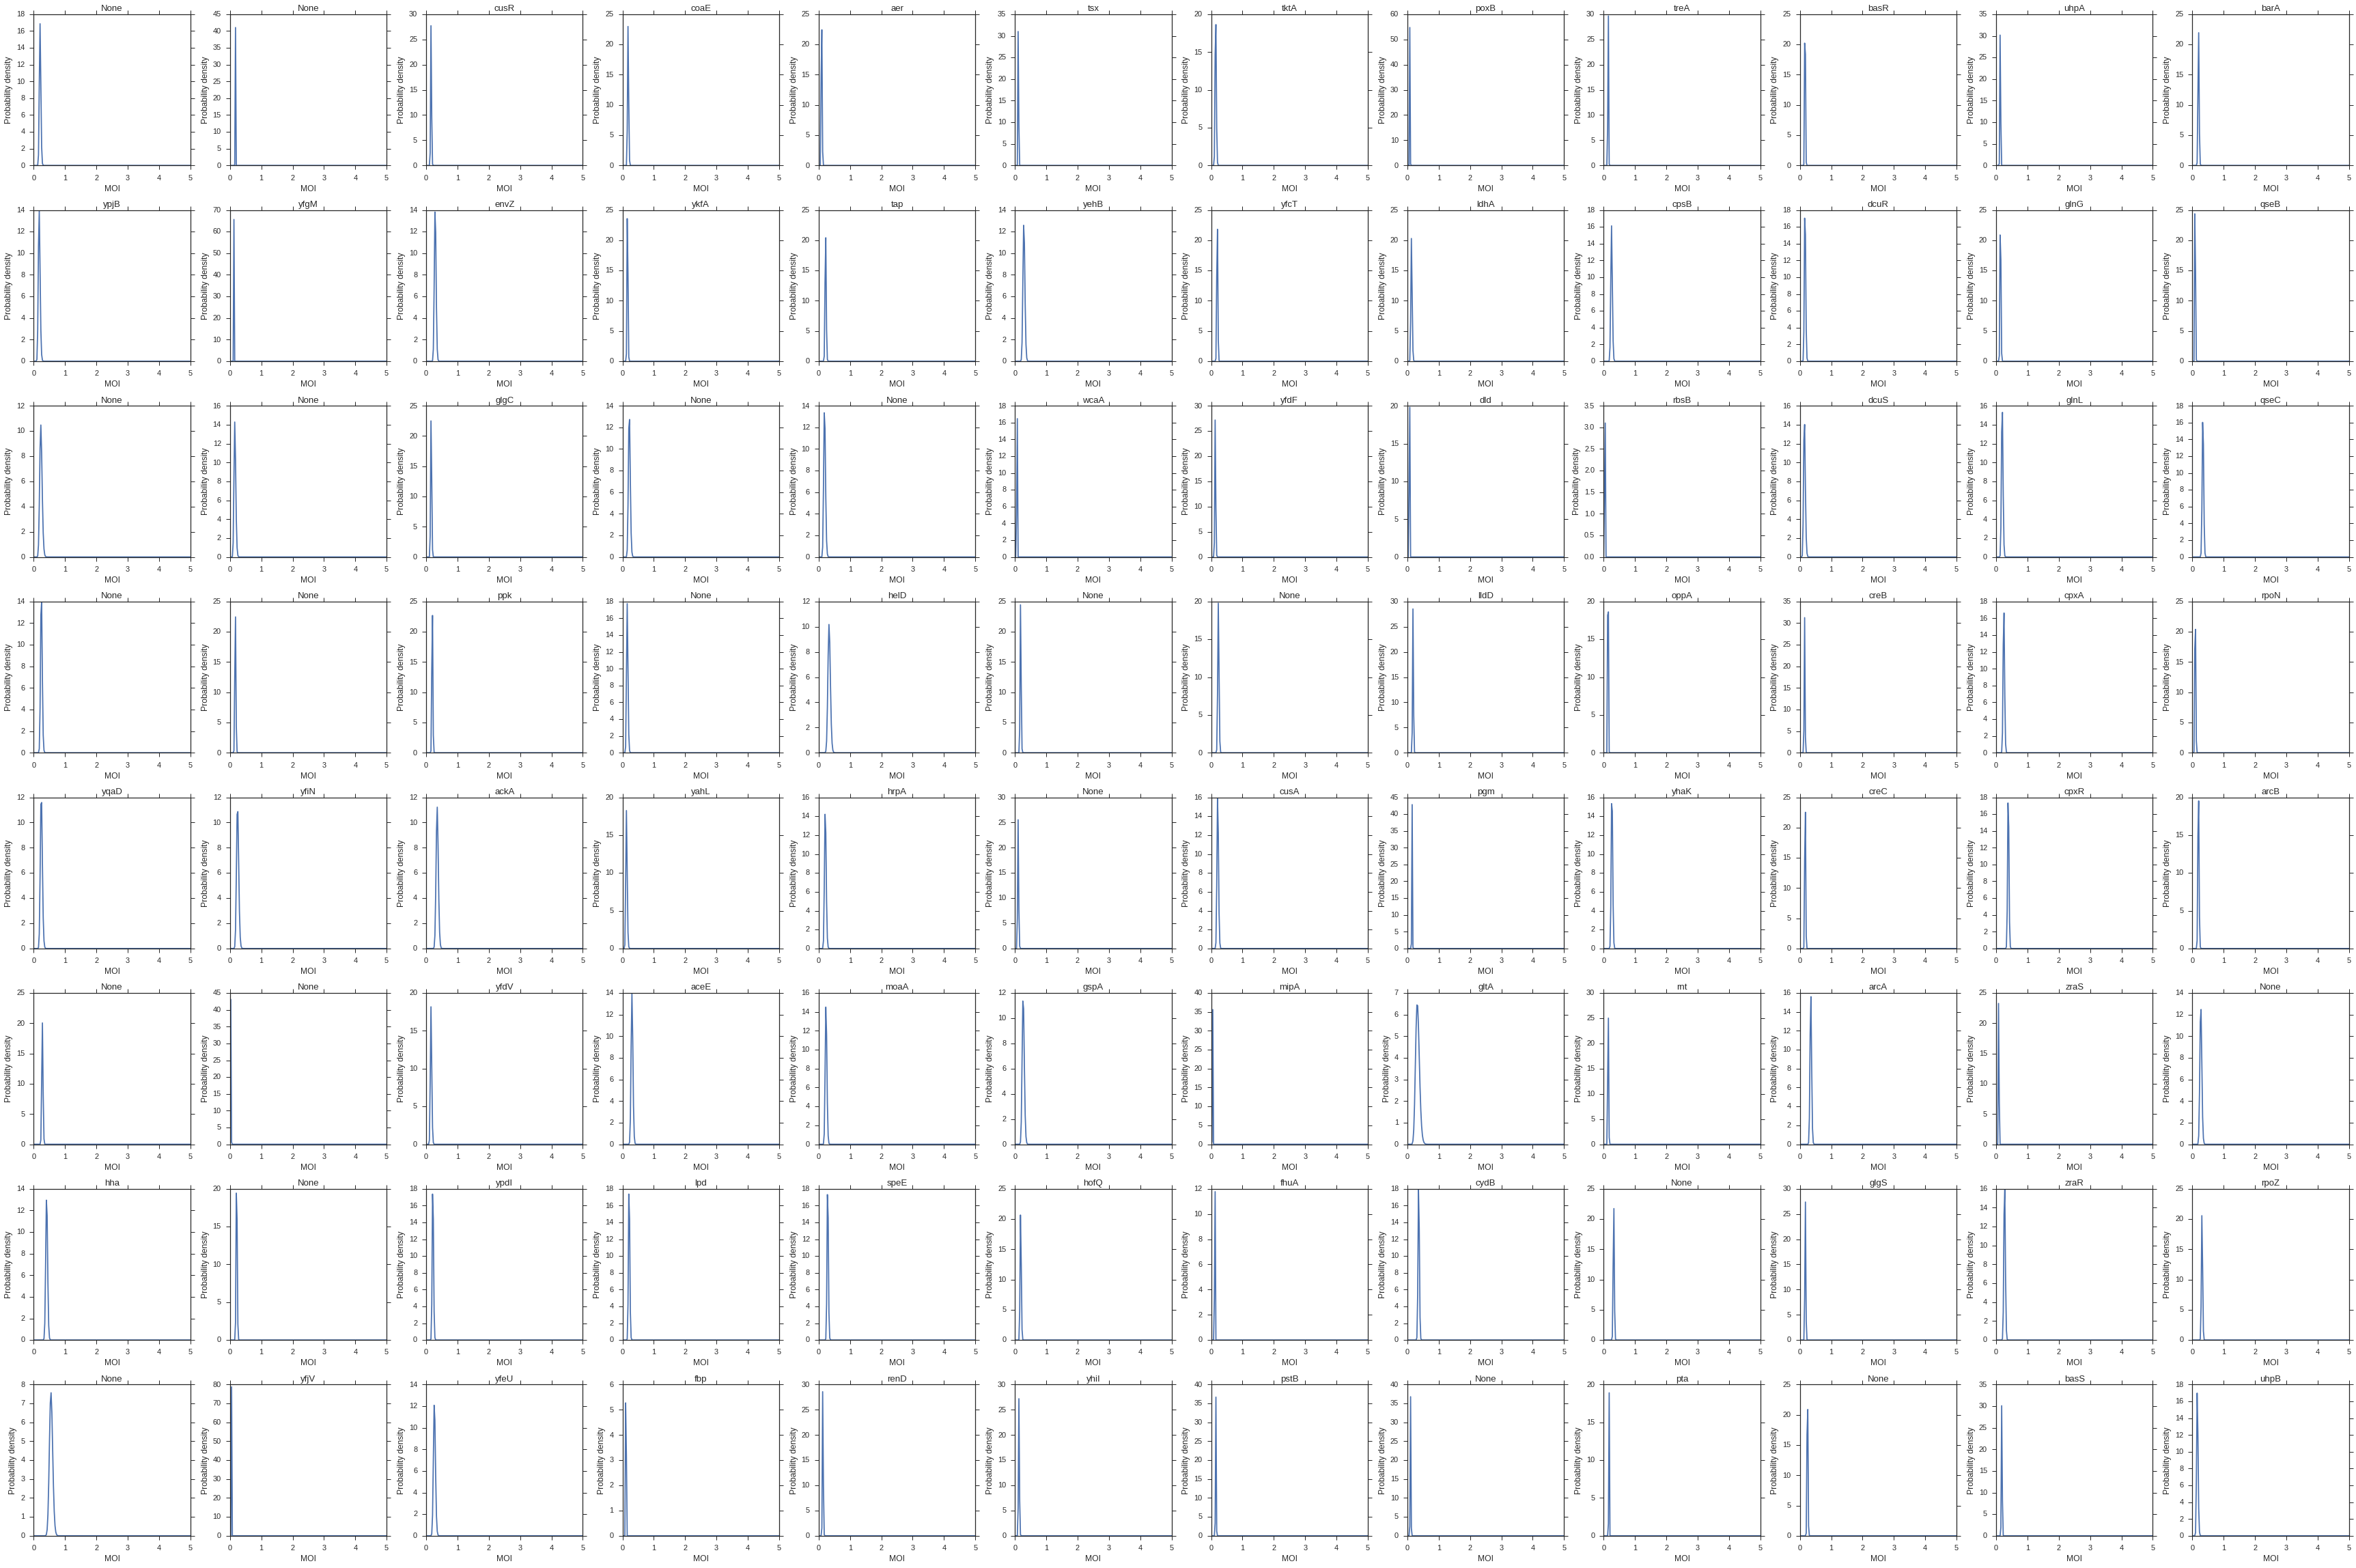

In [22]:
fig, axes = plt.subplots(8,12, figsize = (4*12, 4*8))

def compute_inverse_MOI_posterior(N_infected, N_cells):
    x = np.linspace(0,5,200)
    gamma = np.float(N_cells)*np.log(1-1/np.float(N_cells))
    posterior = np.abs(gamma*np.exp(gamma*x))*scipy.stats.beta.pdf(np.exp(gamma*x), 1+N_cells-N_infected, 1+N_infected)

    return x, posterior

kn = get_keio_names()

for row in row_data:
    for col in col_data:
        well = row + str(col)
        
        well_name = pos_to_strain(kn, plate = plate_number, pos = well)
        p_value = p_values_dict[well]
        infected_cells = np.where(p_value < 0.01)[0]
        fitc_list = np.array(mean_FITC[well])[infected_cells]
        cherry_list = np.array(mean_cherry[well])[infected_cells]

        p_fitc = []
        p_cherry = []
        for fitc, cherry in zip(fitc_list, cherry_list):
            p_fitc += [1-kernel_fitc.integrate_box_1d(fitc, 1e6)]
            p_cherry += [1-kernel_cherry.integrate_box_1d(cherry, 1e6)]

        # Remove double positives
        p_fitc_new = []
        p_cherry_new = []
        fitc_list_new = []
        cherry_list_new = []
        for p_f, p_c, f, c in zip(p_fitc, p_cherry, fitc_list, cherry_list):
            if (p_f < 0.85 and c > 50) or p_c < 0.85:
                p_fitc_new += [p_f]
                p_cherry_new += [p_c]
                fitc_list_new += [f]
                cherry_list_new += [c]

        p_fitc = p_fitc_new
        p_cherry = p_cherry_new
        fitc_list = fitc_list_new
        cherry_list = cherry_list_new

        counter = 0
        for p_f, p_c in zip(p_fitc, p_cherry):
            if p_f > p_c:
                counter += 1
                
        if len(p_fitc) > 0:
            #Uncomment to print p_lysis
            #print well_name, np.float(counter)/len(p_fitc), counter, len(p_fitc)
            x, posterior = compute_inverse_MOI_posterior(infected_cells.shape[0], p_value.shape[0])
            
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 5])
            axes[row_temp, col_temp].set_xlabel('MOI')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
        else:    
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 5])
            axes[row_temp, col_temp].set_xlabel('MOI')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
            
plt.tight_layout()

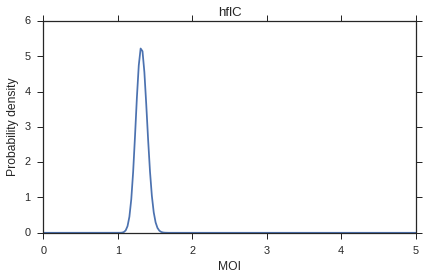

In [20]:
fig = plt.figure()
axes = plt.gca()

def compute_inverse_MOI_posterior(N_infected, N_cells):
    x = np.linspace(0,5,200)
    gamma = np.float(N_cells)*np.log(1-1/np.float(N_cells))
    posterior = np.abs(gamma*np.exp(gamma*x))*scipy.stats.beta.pdf(np.exp(gamma*x), 1+N_cells-N_infected, 1+N_infected)

    return x, posterior

kn = get_keio_names()

well = "B6"
        
well_name = pos_to_strain(kn, plate = plate_number, pos = well)
p_value = p_values_dict[well]
infected_cells = np.where(p_value < 0.01)[0]
fitc_list = np.array(mean_FITC[well])[infected_cells]
cherry_list = np.array(mean_cherry[well])[infected_cells]

p_fitc = []
p_cherry = []
for fitc, cherry in zip(fitc_list, cherry_list):
    p_fitc += [1-kernel_fitc.integrate_box_1d(fitc, 1e6)]
    p_cherry += [1-kernel_cherry.integrate_box_1d(cherry, 1e6)]

# Remove double positives
p_fitc_new = []
p_cherry_new = []
fitc_list_new = []
cherry_list_new = []
for p_f, p_c, f, c in zip(p_fitc, p_cherry, fitc_list, cherry_list):
    if (p_f < 0.85 and c > 50) or p_c < 0.85:
        p_fitc_new += [p_f]
        p_cherry_new += [p_c]
        fitc_list_new += [f]
        cherry_list_new += [c]

p_fitc = p_fitc_new
p_cherry = p_cherry_new
fitc_list = fitc_list_new
cherry_list = cherry_list_new

counter = 0
for p_f, p_c in zip(p_fitc, p_cherry):
    if p_f > p_c:
        counter += 1

if len(p_fitc) > 0:
    #Uncomment to print p_lysis
    #print well_name, np.float(counter)/len(p_fitc), counter, len(p_fitc)
    x, posterior = compute_inverse_MOI_posterior(infected_cells.shape[0], p_value.shape[0])

    alphabet = ['A','B','C','D','E','F','G','H']
    chars = list(well)
    row_temp = alphabet.index(chars[0])
    if len(chars) == 2:
        col_temp = int(chars[1])-1
    if len(chars) == 3:
        col_temp = int(chars[1] + chars[2])-1

    axes.plot(x, posterior)
    axes.set_xlim([0, 5])
    axes.set_xlabel('MOI')
    axes.set_ylabel('Probability density')
    axes.set_title(well_name)
else:    
    alphabet = ['A','B','C','D','E','F','G','H']
    chars = list(well)
    row_temp = alphabet.index(chars[0])
    if len(chars) == 2:
        col_temp = int(chars[1])-1
    if len(chars) == 3:
        col_temp = int(chars[1] + chars[2])-1

    axes.plot(x, posterior)
    axes.set_xlim([0, 5])
    axes.set_xlabel('MOI')
    axes.set_ylabel('Probability density')
    axes.set_title(well_name)
            
plt.tight_layout()